# Jacarandas
> This notebook analyzes and visualizes [Jacaranda trees](https://en.wikipedia.org/wiki/Jacaranda_mimosifolia#:~:text=Jacaranda%20mimosifolia%20is%20a%20sub,poui%2C%20Nupur%20or%20fern%20tree.) in Los Angeles County.

---

#### Load Python tools and Jupyter config

In [6]:
import os
import pandas as pd
import jupyter_black
import geopandas as gpd

In [7]:
jupyter_black.load()
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
profile_name = os.environ.get("AWS_PERSONAL_PROFILE")

In [8]:
today = pd.Timestamp.today().strftime("%Y-%m-%d")

---

## Read

#### Read GeoJSON stored on S3

In [ ]:
src = gpd.read_file(
    "https://stiles-data.s3.us-west-1.amazonaws.com/trees/la_county_tree_locations.geojson"
)

In [ ]:
src = jac_src.copy()

In [41]:
src.head()

,id,place,species,ispalm,mexfanpalm,jacaranda,pine,oak,magnolia,category,camphor,ash,crepemyrtle,geometry
0,0,Santa Clarita,Afghan Pine,False,False,False,True,False,False,pine,False,False,False,POINT (-118.53727 34.44301)
1,1,Long Beach,Vacant,False,False,False,False,False,False,other,False,False,False,POINT (-118.17789 33.83003)
2,2,Pomona,Vacant,False,False,False,False,False,False,other,False,False,False,POINT (-117.73832 34.03497)
3,3,Pomona,Vacant,False,False,False,False,False,False,other,False,False,False,POINT (-117.73933 34.03523)
4,4,Pomona,Vacant,False,False,False,False,False,False,other,False,False,False,POINT (-117.73947 34.03524)


In [62]:
# Step 1: Count all trees in each place
all_trees_count = src.groupby("place").size().reset_index(name="total_trees")

# Step 2: Count all Jacaranda trees in each place
jacarandas_count = (
    src[src["jacaranda"] == True].groupby("place").size().reset_index(name="jacarandas")
)

# Step 3: Merge the two dataframes
merged = pd.merge(all_trees_count, jacarandas_count, on="place", how="left")
merged["jacarandas"] = merged["jacarandas"].fillna(0).astype(int)

# Step 4: Calculate the proportion of Jacarandas
merged["jacaranda_share"] = round(
    (merged["jacarandas"] / merged["total_trees"]) * 100, 2
)

# Step 5: Rank the places based on the proportion of Jacarandas
merged["jacaranda_rank"] = (
    merged["jacaranda_share"].rank(method="min", ascending=False)
).astype(int)

In [63]:
jacaranda_ranks = merged.sort_values("jacaranda_share", ascending=False).reset_index(
    drop=True
)

In [65]:
jacaranda_ranks.head()

,place,total_trees,jacarandas,jacaranda_share,jacaranda_rank
0,West Hollywood,9066,1417,15.63,1
1,Bell Gardens,7127,665,9.33,2
2,South Pasadena,11349,735,6.48,3
3,Whittier,27898,1774,6.36,4
4,Carson,22585,1353,5.99,5


#### Just the Jacarandas

In [66]:
jac_gdf = src.query("jacaranda == True").copy()

In [67]:
jac_gdf.head()

,id,place,species,ispalm,mexfanpalm,jacaranda,pine,oak,magnolia,category,camphor,ash,crepemyrtle,geometry
3487,3487,Long Beach,Jacaranda,False,False,True,False,False,False,jacaranda,False,False,False,POINT (-118.17322 33.77729)
3586,3586,West Hollywood,Jacaranda,False,False,True,False,False,False,jacaranda,False,False,False,POINT (-118.36060 34.09029)
3587,3587,West Hollywood,Jacaranda,False,False,True,False,False,False,jacaranda,False,False,False,POINT (-118.38146 34.08060)
3588,3588,West Hollywood,Jacaranda,False,False,True,False,False,False,jacaranda,False,False,False,POINT (-118.38139 34.08046)
3868,3868,Long Beach,Jacaranda,False,False,True,False,False,False,jacaranda,False,False,False,POINT (-118.17422 33.84376)


---

## Process

In [6]:
def convert_yn_to_boolean(df, columns):
    for column in columns:
        df[column] = df[column].map({"y": True, "n": False})
    return df

#### List of columns to convert

In [7]:
columns_to_convert = [
    "ispalm",
    "mexfanpalm",
    "jacaranda",
    "pine",
    "oak",
    "magnolia",
    "camphor",
    "ash",
    "crepemyrtle",
]

#### Convert those columns

In [8]:
src = convert_yn_to_boolean(src, columns_to_convert)

#### Clean up place and species names

In [9]:
src["place"] = src["place"].str.replace("_", " ").str.title()
src["species"] = src["species"].str.replace("_", " ").str.title()

In [10]:
df = src[
    [
        "id",
        "place",
        "species",
        "ispalm",
        "mexfanpalm",
        "jacaranda",
        "pine",
        "oak",
        "magnolia",
        "category",
        "camphor",
        "ash",
        "crepemyrtle",
        "longitude",
        "latitude",
    ]
].copy()

---

## Analyze

#### How many trees?

In [11]:
len(df)

1603004

#### How many trees without a species specified? 

In [12]:
len(df.query("species == 'Vacant'"))

216742

#### How many distinct species?

In [13]:
len(df.query("species != 'Vacant'")["species"].str.strip().unique())

1387

#### Random five trees

In [14]:
df.sample(5)

,id,place,species,ispalm,mexfanpalm,jacaranda,pine,oak,magnolia,category,camphor,ash,crepemyrtle,longitude,latitude
439383,439383,Los Angeles City,Shamel Ash,False,False,False,False,False,False,ash,False,True,False,-118.487261,34.224724
919774,919774,Pomona,California Pepper,False,False,False,False,False,False,other,False,False,False,-117.784916,34.034359
437022,437022,Santa Clarita,Raywood Ash,False,False,False,False,False,False,ash,False,True,False,-118.545959,34.394571
638244,638244,Los Angeles City,Ornamental Pear,False,False,False,False,False,False,other,False,False,False,-118.576360,34.213842
1377715,1377715,Los Angeles City,Modesto Ash,False,False,False,False,False,False,ash,False,True,False,-118.622188,34.173867


---

## Aggregate

#### How many trees in each place? 

In [15]:
city_counts = (
    df.groupby("place")["id"]
    .count()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
city_counts.head()

,place,count
19,Los Angeles City,540668
18,Long Beach,140822
33,Santa Clarita,111473
20,Los Angeles County,96053
25,Pasadena,71132


#### Species by city

In [16]:
city_species_counts = (
    df.query('species != "Vacant"')
    .groupby(["place", "species"])["id"]
    .count()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)
city_species_counts.head()

,place,species,count
4081,Los Angeles City,Crepe Myrtle,37740
3948,Los Angeles City,American Sweetgum,33627
4244,Los Angeles City,Mexican Fan Palm,25079
4408,Los Angeles City,Southern Magnolia,22838
4249,Los Angeles City,Modesto Ash,14126


#### Jacarandas

In [17]:
city_jacarandas = (
    df.query('species != "Vacant" and jacaranda == True')
    .groupby(["place"])["id"]
    .count()
    .reset_index(name="jacaradas")
    .sort_values("jacaradas", ascending=False)
)
city_jacarandas.head()

,place,jacaradas
19,Los Angeles City,13168
18,Long Beach,6798
20,Los Angeles County,2247
15,Glendale,2031
39,Whittier,1774


#### Function to determine palm tree share of all trees

In [18]:
def calculate_tree_shares(df, place_column, attribute_column):
    """
    Calculate the share of a specific type of tree (indicated by attribute_column)
    out of the total trees, grouped by the specified place column.

    Parameters:
    - df: DataFrame containing the data.
    - place_column: String, name of the column indicating the place (e.g., city, neighborhood).
    - attribute_column: String, name of the boolean column indicating the presence of a specific tree type.

    Returns:
    - DataFrame with columns for place, total trees, count of specified tree type,
      and share of specified tree type, sorted by share in descending order.
    """
    tree_counts = (
        df.groupby(place_column)
        .agg(
            total_trees=pd.NamedAgg(column=attribute_column, aggfunc="count"),
            specific_trees=pd.NamedAgg(column=attribute_column, aggfunc="sum"),
        )
        .reset_index()
    )

    tree_counts["specific_trees"] = tree_counts["specific_trees"].astype(int)

    tree_counts["tree_share"] = (
        (tree_counts["specific_trees"] / tree_counts["total_trees"]) * 100
    ).round(2)

    tree_counts_sorted = tree_counts.sort_values("tree_share", ascending=False)

    return tree_counts_sorted

#### Calculate the share of palm trees

In [19]:
la_county_palm_shares = calculate_tree_shares(df, "place", "ispalm")

#### How many LA trees are palms?

In [20]:
la_county_palm_shares.query('place=="Los Angeles City"').head()

,place,total_trees,specific_trees,tree_share
19,Los Angeles City,540668,41928,7.75


---

## Geography

#### Create a geodataframe

In [21]:
geometry = gpd.points_from_xy(df.longitude, df.latitude)
gdf = (
    gpd.GeoDataFrame(df, geometry=geometry)
    .drop(["longitude", "latitude"], axis=1)
    .set_crs("4326")
)

<Axes: >

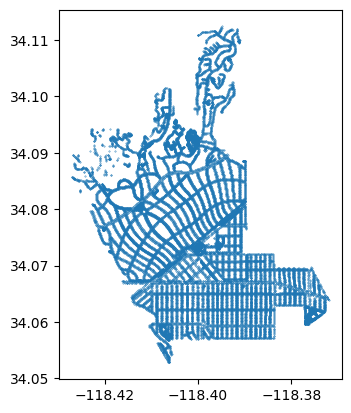

In [22]:
gdf.query('place == "Beverly Hills"').plot(markersize=0.1)

#### LA County cities, unincorporated areas and LA City neighborhoods

In [23]:
cities_gdf = gpd.read_file(
    "https://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Political_Boundaries/MapServer/19/query?outFields=*&where=1%3D1&f=geojson"
)
cities_gdf.columns = cities_gdf.columns.str.lower()

#### Just the city of LA

In [24]:
la_gdf = cities_gdf.query('city_label=="Los Angeles"').dissolve()

<Axes: >

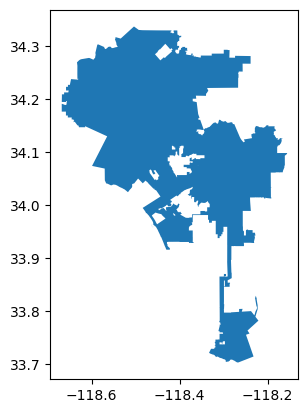

In [25]:
la_gdf.plot()

#### LA city neighborhoods

In [26]:
lahoods_gdf = gpd.read_file(
    "https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
).rename(columns={"OBJECTID": "id"})

In [27]:
lahoods_gdf.head()

,id,name,geometry
0,1,Adams-Normandie,"POLYGON ((-118.30069 34.03731, -118.30388 34.0..."
1,2,Arleta,"POLYGON ((-118.44255 34.26412, -118.44240 34.2..."
2,3,Arlington Heights,"POLYGON ((-118.31862 34.05306, -118.31673 34.0..."
3,4,Atwater Village,"MULTIPOLYGON (((-118.27886 34.15321, -118.2788..."
4,5,Baldwin Hills/Crenshaw,"POLYGON ((-118.36102 34.02532, -118.36026 34.0..."


In [28]:
lahoods_merge = (
    gpd.sjoin(gdf, lahoods_gdf[["name", "geometry"]], predicate="within")
    .drop(["index_right", "id"], axis=1)
    .rename(columns={"name": "neighborhood"})
).reset_index(drop=True)

#### Palms in LA by neighborhood? 

In [29]:
la_city_palm_shares = calculate_tree_shares(lahoods_merge, "neighborhood", "ispalm")

In [30]:
la_city_palm_shares.head()

,neighborhood,total_trees,specific_trees,tree_share
54,Larchmont,871,292,33.52
99,Vermont Square,1330,424,31.88
46,Hollywood,6645,2110,31.75
42,Harvard Heights,426,128,30.05
2,Arlington Heights,1249,368,29.46


#### Jacarandas in LA by neighborhood? 

In [31]:
la_city_jacaranda_shares = calculate_tree_shares(
    lahoods_merge, "neighborhood", "jacaranda"
)

In [32]:
la_city_jacaranda_shares.head()

,neighborhood,total_trees,specific_trees,tree_share
0,Adams-Normandie,935,135,14.44
77,Rancho Park,1809,204,11.28
105,West Los Angeles,5276,548,10.39
63,Montecito Heights,2227,201,9.03
15,Century City,947,77,8.13


#### Magnolias in LA by neighborhood? 

In [33]:
la_city_magnolia_shares = calculate_tree_shares(
    lahoods_merge, "neighborhood", "magnolia"
)

In [34]:
la_city_magnolia_shares.head()

,neighborhood,total_trees,specific_trees,tree_share
106,Westchester,9517,2330,24.48
77,Rancho Park,1809,369,20.40
110,Windsor Square,409,72,17.60
108,Westwood,8683,1149,13.23
15,Century City,947,122,12.88


## Visuals

#### Plot LA city trees over CartoDB base

In [35]:
gdf_la = gdf[gdf["place"] == "Los Angeles City"]

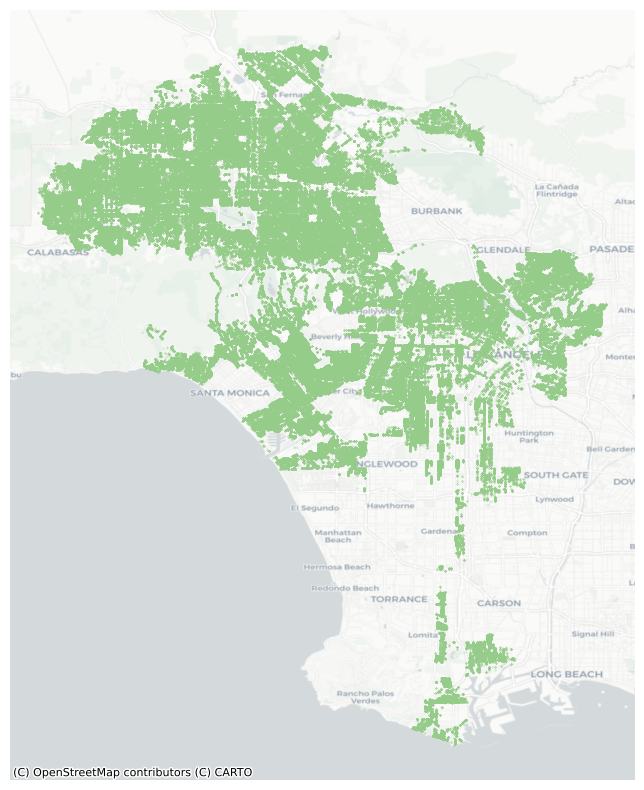

In [36]:
# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the palm tree locations
gdf_la.plot(ax=ax, color="#95cc89", markersize=0.05)

# Add a basemap. The crs parameter is important for aligning the data with the basemap
cx.add_basemap(ax, crs=gdf_la.crs.to_string(), source=cx.providers.CartoDB.Positron)

# Set the axis to equal aspect ratio
ax.set_aspect("equal")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])

# Remove the border
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

#### Palm trees in LA?

In [37]:
gdf_palm = gdf_la.query("ispalm == True")
gdf_non_palm = gdf_la.query("ispalm == False")

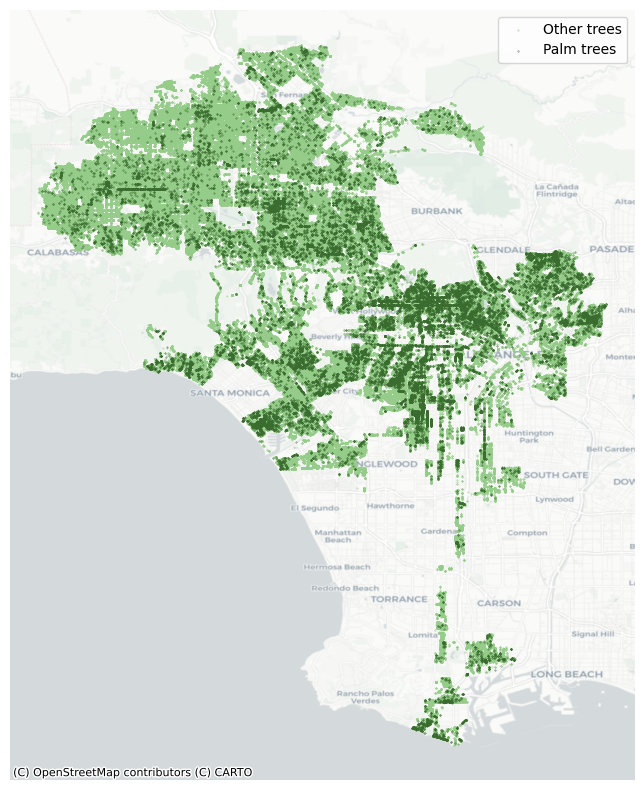

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

gdf_non_palm.plot(ax=ax, color="#95cc89", markersize=0.1, label="Other trees")
gdf_palm.plot(ax=ax, color="#396c2e", markersize=0.1, label="Palm trees")

cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Positron)

ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])

ax.legend()

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

---

## Exports

#### JSON

In [39]:
# df.to_json(
#     "../data/processed/la_county_tree_locations.json", indent=4, orient="records"
# )

#### CSV

In [40]:
# df.to_csv("../data/processed/la_county_tree_locations.csv", index=False)

#### GeoJSON

In [41]:
# gdf.to_file(
#     "../data/processed/la_tree_locations_locations.geojson",
#     driver="GeoJSON",
# )

#### Parquet

In [42]:
# df_p = df.copy()
# table = pa.Table.from_pandas(df_p)
# pq.write_table(table, "../data/small/la_county_tree_locations.parquet")

#### Store on s3
> Download: https://stiles-data.s3.us-west-1.amazonaws.com/trees/{file_name_here.filetype}

In [43]:
# !aws s3 cp ../data/processed/la_county_tree_locations.json s3://stiles-data/trees/la_county_tree_locations.json --profile {profile_name}

In [44]:
# !aws s3 cp ../data/processed/la_county_tree_locations.csv s3://stiles-data/trees/la_county_tree_locations.csv --profile {profile_name}

In [45]:
# !aws s3 cp ../data/processed/la_tree_locations_locations.geojson s3://stiles-data/trees/la_county_tree_locations.geojson --profile {profile_name}

In [46]:
# !aws s3 cp ../data/small/la_county_tree_locations.parquet s3://stiles-data/trees/la_county_tree_locations.parquet --profile {profile_name}